In [1]:
import hyperloglog
import random
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

In [48]:
from matplotlib import rc, rcParams
rc('axes', linewidth=1)
rc('font', size=14)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
def coordinator_processing(coordinator, index, updated_centers, bits, number_bits, num_iterations):
    for _ in range(num_iterations):
        # print(index)
        intermediate_M = [[0 for _ in range(0, index)] + center.M[index:min(index+bits,number_bits)] + [0 for _ in range(min(index+bits,number_bits),number_bits)] for center in updated_centers]

        for i in range(len(updated_centers)):
            coordinator.update_M(intermediate_M[i])
        
        top_half_indices = sorted(
            range(len(updated_centers)),
            key=lambda i: np.mean(centers[i].M[:min(index+bits,number_bits)]) if len(centers[i].M) >= 10 else -np.inf,
            reverse=True
        )[:len(updated_centers) // 2]

        updated_centers = [centers[i] for i in top_half_indices]
        
        # print(len(updated_centers))
        index = min(index+bits,number_bits)

## Uniform distribution of items across centers

### Ablation by varying p

In [3]:
# Parameters
k = 64  # Number of HLL centers
precision = 0.01
num_trials = 10
m_values = [5000, 10000, 50000, 100000, 200000] # Different dataset sizes
p_values = [100, 500, 1000, 2000, 5000, 10000]  # Number of unique elements

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [5]:
# Run experiment
results_pm = []

num_iterations = int(math.log(k, 2)) + 1

for m in m_values:
    for p in tqdm(p_values, desc=f"Running experiments for m={m}"):
        pool = [random_string() for _ in range(p)]
        for trial in range(num_trials):
            # Sample m items from the pool with replacement
            items = random.choices(pool, k=m)

            # One-center estimate
            hll_one = hyperloglog.HyperLogLog(precision)
            for item in items:
                hll_one.add(item)
            one_center_est = len(hll_one)

            # Distributed estimate
            centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
            for item in items:
                centers[random.randint(0, k - 1)].add(item)

            coordinator = hyperloglog.HyperLogLog(precision)
            updated_centers = centers
            number_bits = len(coordinator.M)
            index = 0
            bits = math.ceil(number_bits / num_iterations)

            coordinator_processing(coordinator, index, updated_centers, bits, number_bits, num_iterations)
            distributed_est = len(coordinator)

            # Store errors
            results_pm.append({
                "p": p,
                "m": m,
                "mode": "One Center",
                "abs_error": abs(one_center_est - len(set(items))) / len(set(items))
            })
            results_pm.append({
                "p": p,
                "m": m,
                "mode": "Distributed",
                "abs_error": abs(distributed_est - len(set(items))) / len(set(items))
            })

# Convert to DataFrame
df_pm = pd.DataFrame(results_pm)


Running experiments for m=200000: 100%|██████████| 6/6 [01:36<00:00, 16.15s/it]


In [6]:
df_pm

,p,m,mode,abs_error
0,100,5000,One Center,0.0100
1,100,5000,Distributed,0.1000
2,100,5000,One Center,0.0100
3,100,5000,Distributed,0.0900
4,100,5000,One Center,0.0100
...,...,...,...,...
595,10000,200000,Distributed,0.2501
596,10000,200000,One Center,0.0022
597,10000,200000,Distributed,0.2588
598,10000,200000,One Center,0.0022


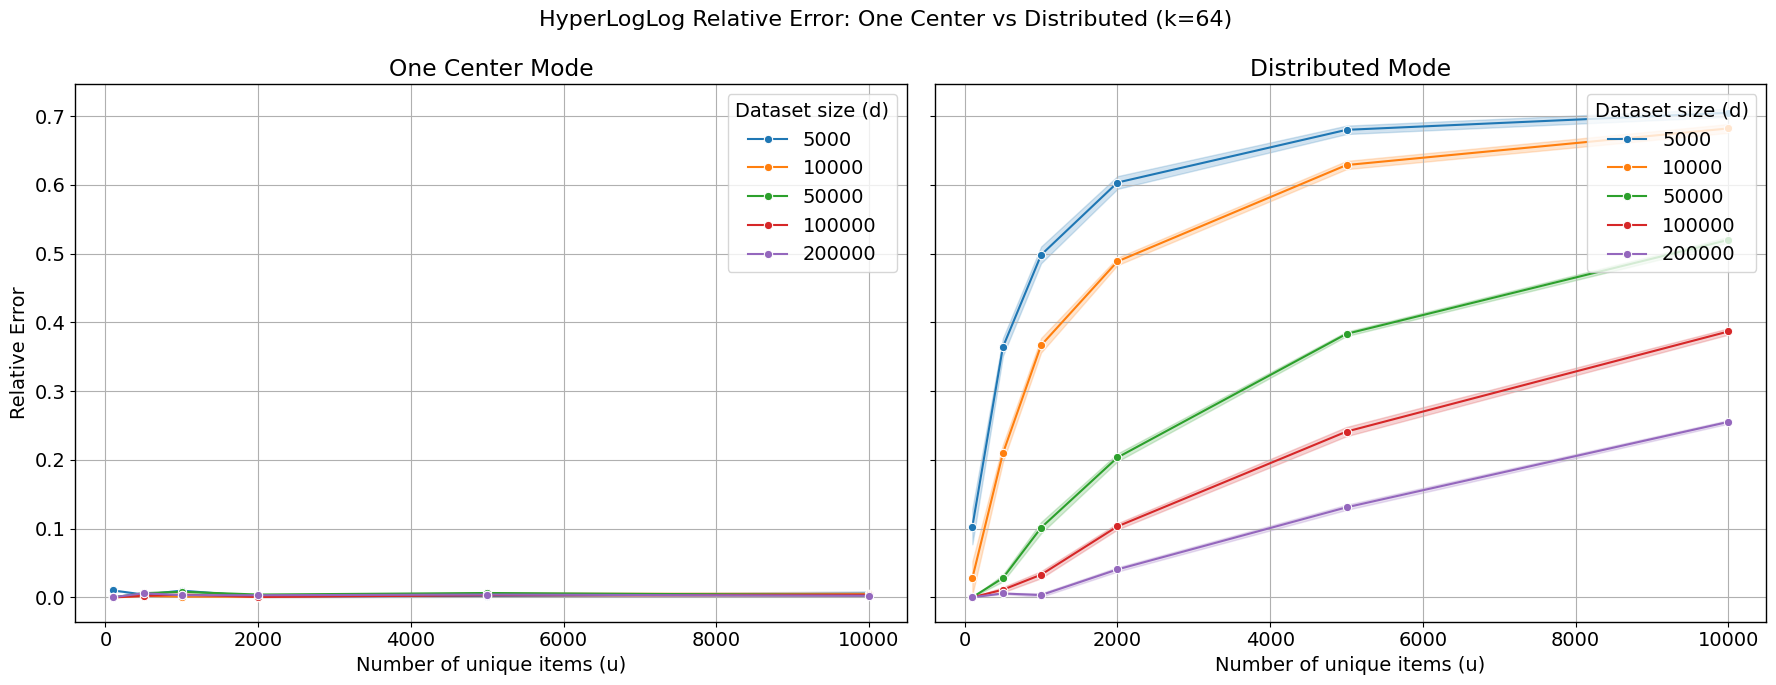

In [69]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Relative Error"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    modes = ["One Center", "Distributed"]
    for ax, mode in zip(axes, modes):
        df_mode = df[df["mode"] == mode]
        sns.lineplot(
            data=df_mode, x="p", y=y, hue="m", marker="o", ax=ax, palette="tab10", errorbar="sd"
        )
        ax.set_title(f"{mode} Mode")
        ax.set_xlabel("Number of unique items (u)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(title="Dataset size (d)", loc='upper right')

    plt.suptitle("HyperLogLog Relative Error: One Center vs Distributed (k=64) ", fontsize=16)
    plt.tight_layout()
    plt.savefig("uniform_pm_ablation.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()



# Call the updated plot
plot_distributed_and_one_center(df_pm)

### Ablation by varying k

In [8]:
# Parameters
precision = 0.01
num_trials = 10
p = 2000 # Number of unique items
m_values = [5000, 10000, 50000, 100000, 200000] # Different dataset sizes
k_values = [2, 4, 8, 16, 32, 64, 128] # Total unique elements

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [9]:
# Run experiment
results_km = []
pool = [random_string() for _ in range(p)]

for m in m_values:
    for k in tqdm(k_values, desc=f"Running experiments for m={m}"):
        num_iterations = int(math.log(k, 2)) + 1
        for trial in range(num_trials):
            # Sample m items from the pool with replacement
            items = random.choices(pool, k=m)

            # One-center estimate
            hll_one = hyperloglog.HyperLogLog(precision)
            for item in items:
                hll_one.add(item)
            one_center_est = len(hll_one)

            # Distributed estimate
            centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
            for item in items:
                centers[random.randint(0, k - 1)].add(item)

            coordinator = hyperloglog.HyperLogLog(precision)
            updated_centers = centers
            number_bits = len(coordinator.M)
            index = 0
            bits = math.ceil(number_bits / num_iterations)

            coordinator_processing(coordinator, index, updated_centers, bits, number_bits, num_iterations)
            distributed_est = len(coordinator)

            # Store errors
            results_km.append({
                "k": k,
                "m": m,
                "mode": "One Center",
                "abs_error": abs(one_center_est - len(set(items))) / len(set(items))
            })
            results_km.append({
                "k": k,
                "m": m,
                "mode": "Distributed",
                "abs_error": abs(distributed_est - len(set(items))) / len(set(items))
            })

# Convert to DataFrame
df_km = pd.DataFrame(results_km)


Running experiments for m=200000: 100%|██████████| 7/7 [01:32<00:00, 13.22s/it]


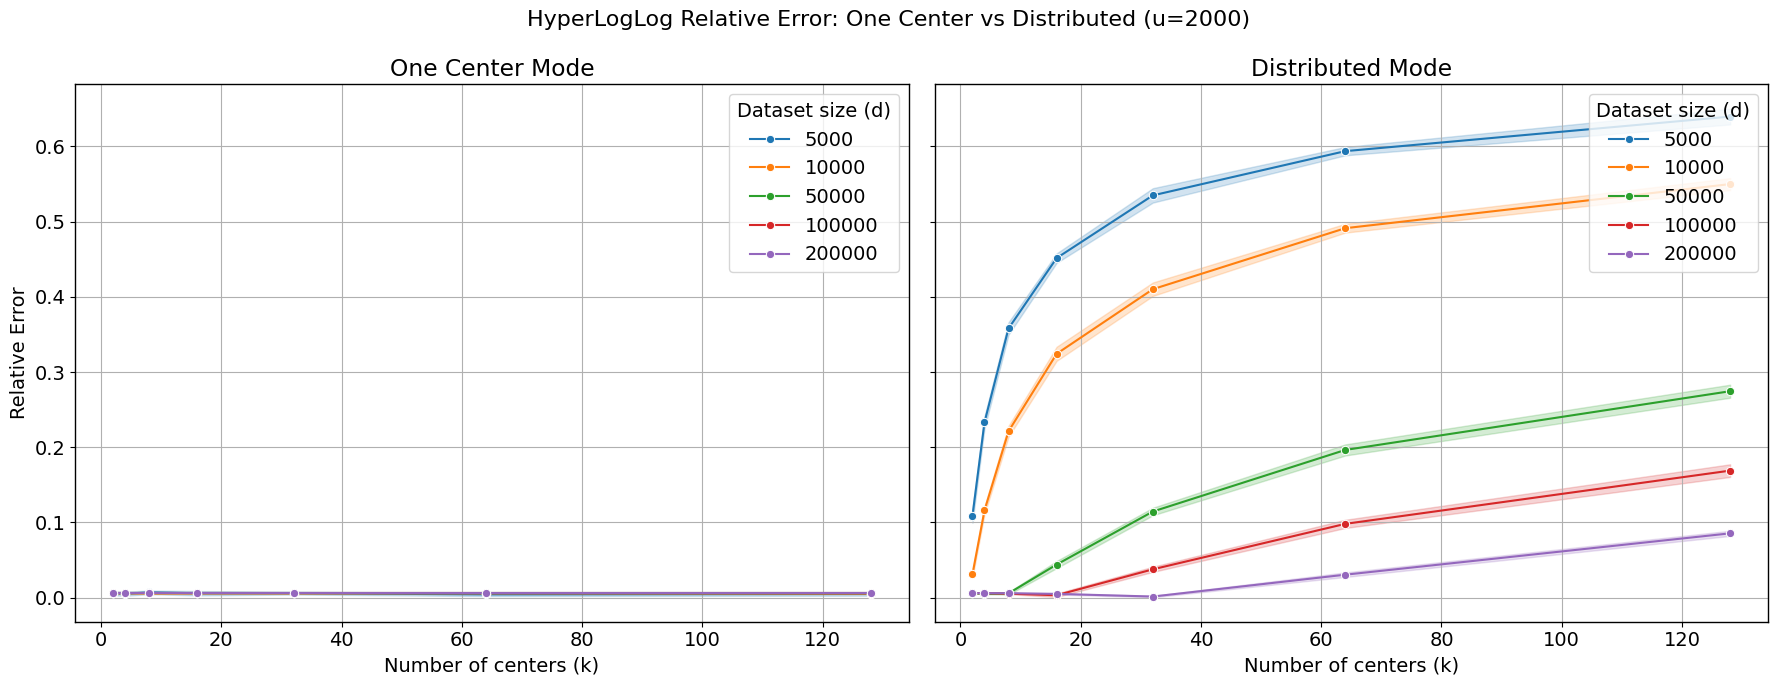

In [70]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Relative Error"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    modes = ["One Center", "Distributed"]
    for ax, mode in zip(axes, modes):
        df_mode = df[df["mode"] == mode]
        sns.lineplot(
            data=df_mode, x="k", y=y, hue="m", marker="o", ax=ax, palette="tab10", errorbar="sd"
        )
        ax.set_title(f"{mode} Mode")
        ax.set_xlabel("Number of centers (k)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(title="Dataset size (d)", loc='upper right')

    plt.suptitle("HyperLogLog Relative Error: One Center vs Distributed (u=2000)", fontsize=16)
    plt.tight_layout()
    plt.savefig("uniform_km_ablation.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()



# Call the updated plot
plot_distributed_and_one_center(df_km)

## Skewed distribution of items across centers

### Ablation by varying p

In [22]:
# Parameters
k = 64  # Number of HLL centers
precision = 0.01
num_trials = 10
m_values = [5000, 10000, 50000, 100000, 200000] # Different dataset sizes
p_values = [100, 500, 1000, 2000, 5000, 10000]  # Number of unique elements
weights = [1 / math.exp(k) for k in range(k)]

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [23]:
# Run experiment
results_pm_sk = []

num_iterations = int(math.log(k, 2)) + 1

for m in m_values:
    for p in tqdm(p_values, desc=f"Running experiments for m={m}"):
        pool = [random_string() for _ in range(p)]
        for trial in range(num_trials):
            # Sample m items from the pool with replacement
            items = random.choices(pool, k=m)

            # One-center estimate
            hll_one = hyperloglog.HyperLogLog(precision)
            for item in items:
                hll_one.add(item)
            one_center_est = len(hll_one)

            # Distributed estimate
            centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
            for item in items:
                # centers[random.randint(0, k - 1)].add(item)
                center_idx = random.choices([l for l in range(k)], weights = weights, k=1)[0]
                centers[center_idx].add(item)

            coordinator = hyperloglog.HyperLogLog(precision)
            updated_centers = centers
            number_bits = len(coordinator.M)
            index = 0
            bits = math.ceil(number_bits / num_iterations)

            coordinator_processing(coordinator, index, updated_centers, bits, number_bits, num_iterations)
            distributed_est = len(coordinator)

            # Store errors
            results_pm_sk.append({
                "p": p,
                "m": m,
                "mode": "One Center",
                "abs_error": abs(one_center_est - len(set(items))) / len(set(items))
            })
            results_pm_sk.append({
                "p": p,
                "m": m,
                "mode": "Distributed",
                "abs_error": abs(distributed_est - len(set(items))) / len(set(items))
            })

# Convert to DataFrame
df_pm_sk = pd.DataFrame(results_pm_sk)


Running experiments for m=200000: 100%|██████████| 6/6 [02:25<00:00, 24.24s/it]


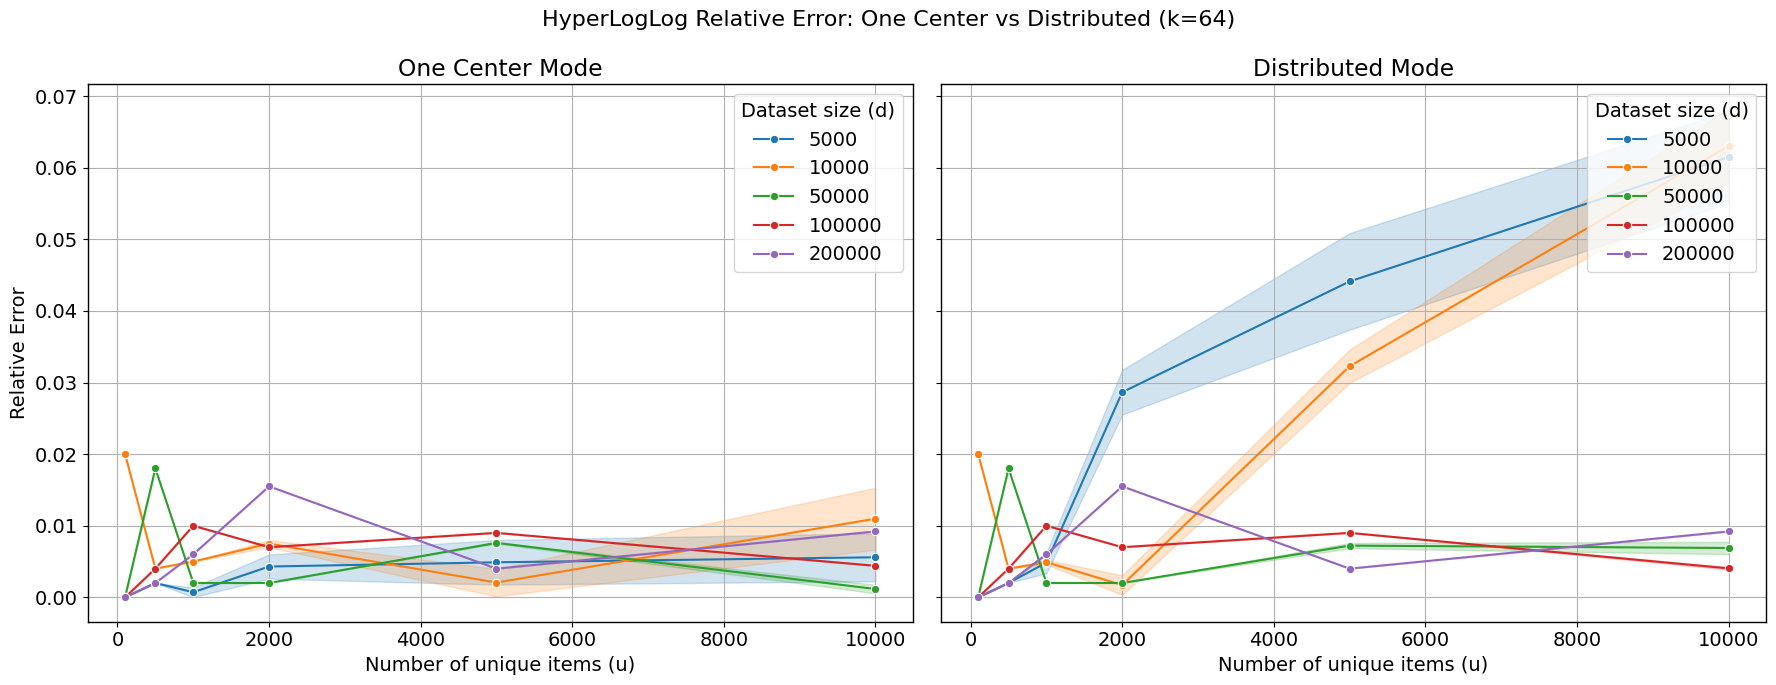

In [71]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Relative Error"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    modes = ["One Center", "Distributed"]
    for ax, mode in zip(axes, modes):
        df_mode = df[df["mode"] == mode]
        sns.lineplot(
            data=df_mode, x="p", y=y, hue="m", marker="o", ax=ax, palette="tab10", errorbar="sd"
        )
        ax.set_title(f"{mode} Mode")
        ax.set_xlabel("Number of unique items (u)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(title="Dataset size (d)", loc='upper right')

    plt.suptitle("HyperLogLog Relative Error: One Center vs Distributed (k=64)", fontsize=16)
    plt.tight_layout()
    plt.savefig("skewed_pm_ablation.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()



# Call the updated plot
plot_distributed_and_one_center(df_pm_sk)

### Ablation by varying k

In [32]:
# Parameters
precision = 0.01
num_trials = 10
p = 2000 # Number of unique items
m_values = [5000, 10000, 50000, 100000, 200000] # Different dataset sizes
k_values = [2, 4, 8, 16, 32, 64, 128] # Total unique elements


# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [34]:
# Run experiment
results_km_sk = []
pool = [random_string() for _ in range(p)]

for m in m_values:
    for k in tqdm(k_values, desc=f"Running experiments for m={m}"):
        num_iterations = int(math.log(k, 2)) + 1
        weights = [1 / math.exp(k) for k in range(k)]
        for trial in range(num_trials):
            # Sample m items from the pool with replacement
            items = random.choices(pool, k=m)

            # One-center estimate
            hll_one = hyperloglog.HyperLogLog(precision)
            for item in items:
                hll_one.add(item)
            one_center_est = len(hll_one)

            # Distributed estimate
            centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
            for item in items:
                # centers[random.randint(0, k - 1)].add(item)
                center_idx = random.choices([l for l in range(k)], weights = weights, k=1)[0]
                centers[center_idx].add(item)

            coordinator = hyperloglog.HyperLogLog(precision)
            updated_centers = centers
            number_bits = len(coordinator.M)
            index = 0
            bits = math.ceil(number_bits / num_iterations)

            coordinator_processing(coordinator, index, updated_centers, bits, number_bits, num_iterations)
            distributed_est = len(coordinator)

            # Store errors
            results_km_sk.append({
                "k": k,
                "m": m,
                "mode": "One Center",
                "abs_error": abs(one_center_est - len(set(items))) / len(set(items))
            })
            results_km_sk.append({
                "k": k,
                "m": m,
                "mode": "Distributed",
                "abs_error": abs(distributed_est - len(set(items))) / len(set(items))
            })

# Convert to DataFrame
df_km_sk = pd.DataFrame(results_km_sk)


Running experiments for m=200000: 100%|██████████| 7/7 [02:18<00:00, 19.74s/it]


In [37]:
df_km_sk[df_km_sk['m'] == 100000]

,k,m,mode,abs_error
420,2,100000,One Center,0.001
421,2,100000,Distributed,0.001
422,2,100000,One Center,0.001
423,2,100000,Distributed,0.001
424,2,100000,One Center,0.001
...,...,...,...,...
555,128,100000,Distributed,0.001
556,128,100000,One Center,0.001
557,128,100000,Distributed,0.001
558,128,100000,One Center,0.001


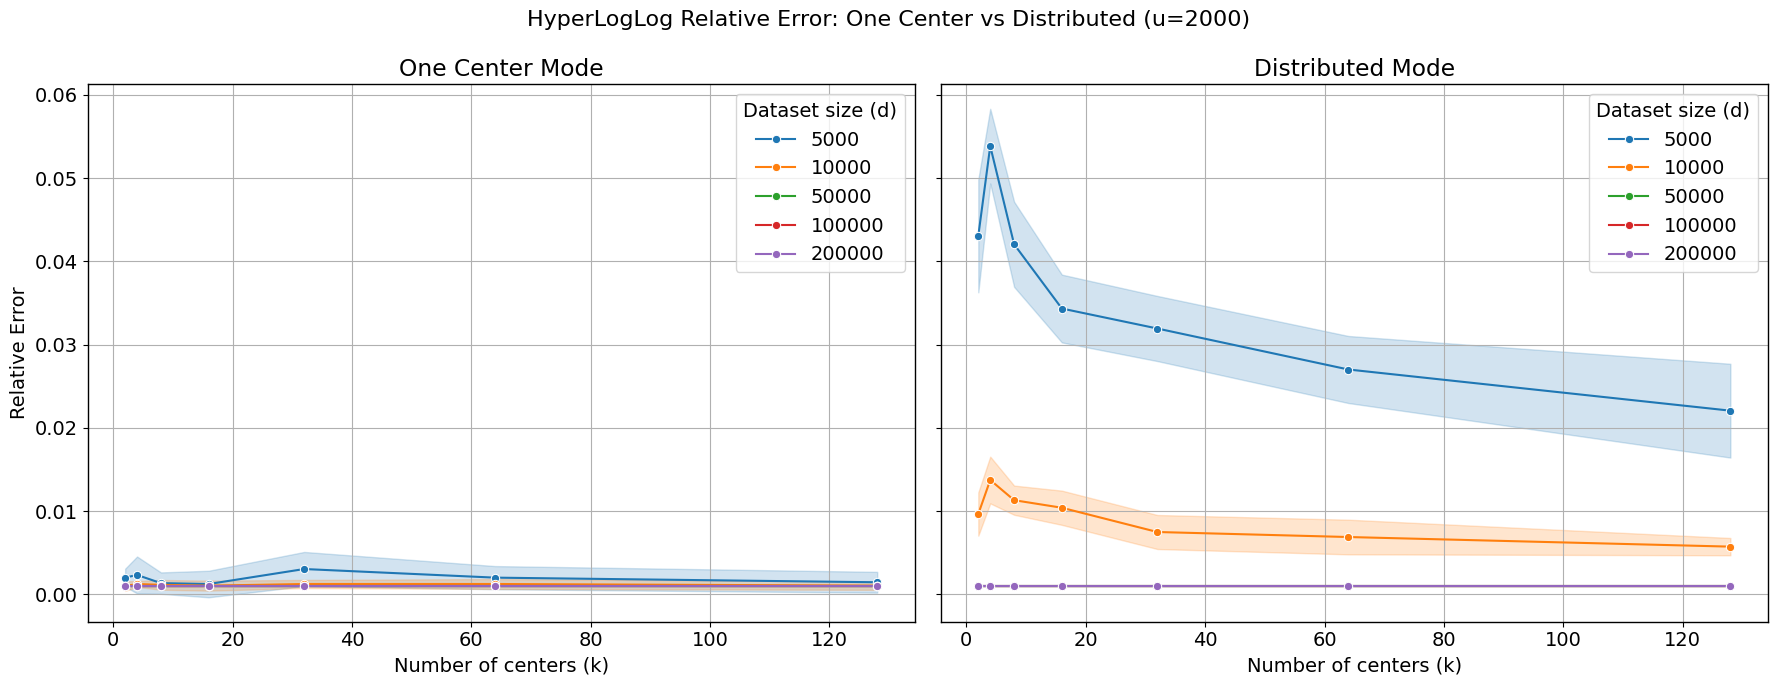

In [72]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Relative Error"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    modes = ["One Center", "Distributed"]
    for ax, mode in zip(axes, modes):
        df_mode = df[df["mode"] == mode]
        sns.lineplot(
            data=df_mode, x="k", y=y, hue="m", marker="o", ax=ax, palette="tab10", errorbar="sd"
        )
        ax.set_title(f"{mode} Mode")
        ax.set_xlabel("Number of centers (k)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(title="Dataset size (d)", loc='upper right')

    plt.suptitle("HyperLogLog Relative Error: One Center vs Distributed (u=2000)", fontsize=16)
    plt.tight_layout()
    plt.savefig("skewed_km_ablation.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


# Call the updated plot
plot_distributed_and_one_center(df_km_sk)